In [ ]:
# Feed-Forward Neural Network (FFN), BASELINE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SECTION: HELPER CLASSES/FUNCTIONS

import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset

def convert_specific_date_format_to_days(df, date_format='%Y-%m-%d', reference_date='2014-01-01'):
    reference_date = pd.to_datetime(reference_date)

    for column in df.columns:
        try:
            converted_column = pd.to_datetime(df[column], format=date_format, errors='raise')
            df[column] = (converted_column - reference_date).dt.days
        except (ValueError, TypeError):
            continue

    return df

def clean_numeric_values(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
          df[column] = df[column].interpolate(method='linear', limit_direction='both', axis=0)
        if pd.api.types.is_datetime64_any_dtype(df[column]) or pd.api.types.is_numeric_dtype(df[column]):
            continue
        df[column] = (
            df[column]
            .astype(str)
            .str.replace(',', '', regex=True)
            .str.replace('K', 'e3', regex=True)
            .str.replace('%', '', regex=True)
            .str.strip()
        )

        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column] = df[column].interpolate(method='linear', limit_direction='both', axis=0)

    return df

def clean_dataframe(df):
    df = convert_specific_date_format_to_days(df)
    df = clean_numeric_values(df)

    return df

class FFNDataset(Dataset):
    def __init__(self, crop_file, feature_file=None, label_idx=2):
        merged_data = clean_dataframe(pd.read_csv(crop_file))
        merged_data = merged_data.iloc[:, [0, label_idx]]

        if feature_file:
          weather_data = clean_dataframe(pd.read_csv(feature_file))
          merged_data = pd.merge(merged_data, weather_data, on='date', how='inner')

        self.labels = merged_data.iloc[:, 1].values
        self.features = merged_data.drop(merged_data.columns[1], axis=1).values.T

        self.features[0] = self.features[0] % 365

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if len(self.labels):
          items = []

          for i in self.features:
            items.append(i[idx])

          return np.array(items + [self.labels[idx]]).T

    def num_features(self):
        return self.features.shape[0]

def calculate_accuracy(model, dataloader, threshold=0.1):
    correct_predictions = 0
    total_samples = 0

    for batch in dataloader:
        features, labels = batch[:, :-1], batch[:, -1]
        outputs = model(features.float())
        predictions = outputs.squeeze()
        absolute_diff = torch.abs(predictions - labels.float())
        correct_predictions += torch.sum(absolute_diff <= threshold)
        total_samples += len(labels)

    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
from torch.utils.data import DataLoader

# SECTION: Read dataset
corn_path = "/content/drive/MyDrive/CSC413 Final Project/US corn/us_corn_price.csv"

weather_path = "/content/drive/MyDrive/CSC413 Final Project/Weather/Merged_Weather.csv"
int_path = "/content/drive/MyDrive/CSC413 Final Project/int corn/Merged_Int.csv"
crop_path = "/content/drive/MyDrive/CSC413 Final Project/Related Crops/Merged_Crop.csv"

weather_dataset = FFNDataset(crop_file=corn_path, feature_file=weather_path)
int_dataset = FFNDataset(crop_file=corn_path, feature_file=int_path)
crop_dataset = FFNDataset(crop_file=corn_path, feature_file=crop_path)

# SECTION: Seperate data into training and test set
N = 2000
batch_size = 64

print(len(crop_dataset))

weather_training_data = weather_dataset[:N]
weather_test_data = weather_dataset[N:]

int_training_data = int_dataset[:N]
int_test_data = int_dataset[N:]

crop_training_data = crop_dataset[:N]
crop_test_data = crop_dataset[N:]



weather_train_dataloader = DataLoader(weather_training_data, batch_size=batch_size, shuffle=True, drop_last=True)
weather_test_dataloader = DataLoader(weather_test_data, batch_size=batch_size, drop_last=True)



int_train_dataloader = DataLoader(int_training_data, batch_size=batch_size, shuffle=True , drop_last=True)
int_test_dataloader = DataLoader(int_test_data, batch_size=batch_size, drop_last=True)

crop_train_dataloader = DataLoader(crop_training_data, batch_size=batch_size, shuffle=True, drop_last=True)
crop_test_dataloader = DataLoader(crop_test_data, batch_size=batch_size, drop_last=True)

print(crop_train_dataloader)

2520


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# SECTION: Create Model and setup params
class FFNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(FFNModel, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout_prob))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define hyperparameters
dropout_prob = 0.1
output_size = 1

# Initialize the models
weather_model = FFNModel(weather_dataset.num_features(), [70, 50, 30], output_size, dropout_prob)
int_model = FFNModel(int_dataset.num_features(), [70, 50, 30], output_size, dropout_prob)
crop_model = FFNModel(crop_dataset.num_features(), [70, 50, 30], output_size, dropout_prob)

In [ ]:
# SECTION: Training loop
def train(model, training_set, testing_set, epochs, learning_rate):
  model.train()

  # Define loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Initialize lists to store loss and accuracy values
  training_losses = []
  testing_losses = []

  for epoch in range(epochs):

      # Training Loss
      train_epoch_loss = 0
      for batch in training_set:
          features, labels = batch[:, :-1], batch[:, -1]
          optimizer.zero_grad()
          outputs = model(features.float())
          loss = criterion(outputs.squeeze(), labels.float())
          loss.backward()
          optimizer.step()
          train_epoch_loss += loss.item()

      training_losses.append(train_epoch_loss / len(training_set))

      # Test Loss
      test_epoch_loss = 0
      for batch in testing_set:
          features, labels = batch[:, :-1], batch[:, -1]
          outputs = model(features.float())
          loss = criterion(outputs.squeeze(), labels.float())
          test_epoch_loss += loss.item()

      testing_losses.append(test_epoch_loss / len(testing_set))

      if (epoch + 1) % (epochs // 10) == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {training_losses[-1]:.4f}, Test Loss {testing_losses[-1]:.4f}')

  # Save the trained model
  torch.save(model.state_dict(), 'ffn_model.pth')
  return (training_losses, testing_losses)

print("Weather Model Training:")
weather_losses = train(weather_model, weather_train_dataloader, weather_test_dataloader, 250, 0.0001)

print("\nInternational Model Training:")
int_losses = train(int_model, int_train_dataloader, int_test_dataloader, 250, 0.0002)

print("\nCrop Model Training:")
crop_losses = train(crop_model, crop_train_dataloader, crop_test_dataloader, 250, 0.0002)

Weather Model Training:
Epoch [25/250], Train Loss: 38401.4405, Test Loss 18255.3712
Epoch [50/250], Train Loss: 27830.0047, Test Loss 12498.6324
Epoch [75/250], Train Loss: 27534.3483, Test Loss 11889.4533
Epoch [100/250], Train Loss: 27741.3258, Test Loss 12996.7842
Epoch [125/250], Train Loss: 26051.4894, Test Loss 12999.7109
Epoch [150/250], Train Loss: 25547.0478, Test Loss 12928.8750
Epoch [175/250], Train Loss: 26294.0226, Test Loss 12494.2054
Epoch [200/250], Train Loss: 26637.7671, Test Loss 12629.1532
Epoch [225/250], Train Loss: 26153.7307, Test Loss 11773.6999
Epoch [250/250], Train Loss: 25696.5147, Test Loss 11142.8644

International Model Training:
Epoch [25/250], Train Loss: 45100.9459, Test Loss 24088.9111
Epoch [50/250], Train Loss: 25329.8560, Test Loss 16484.3149
Epoch [75/250], Train Loss: 19385.2618, Test Loss 17369.9316
Epoch [100/250], Train Loss: 14586.8514, Test Loss 18106.0134
Epoch [125/250], Train Loss: 13631.4970, Test Loss 18077.6133
Epoch [150/250], Trai

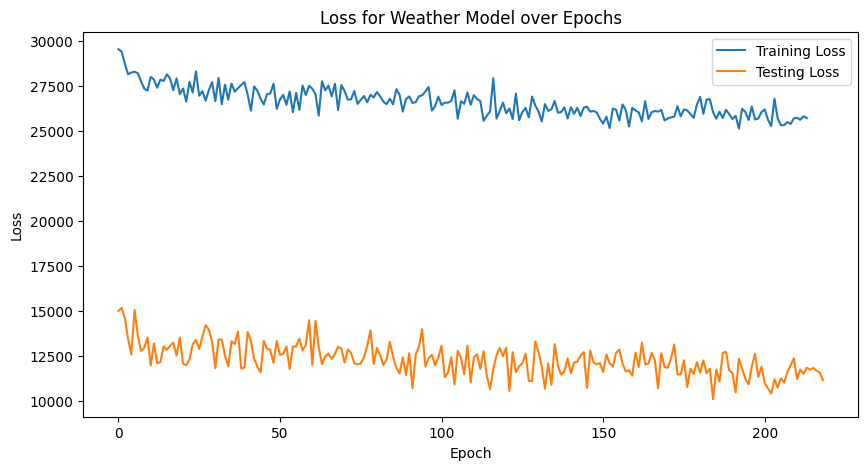

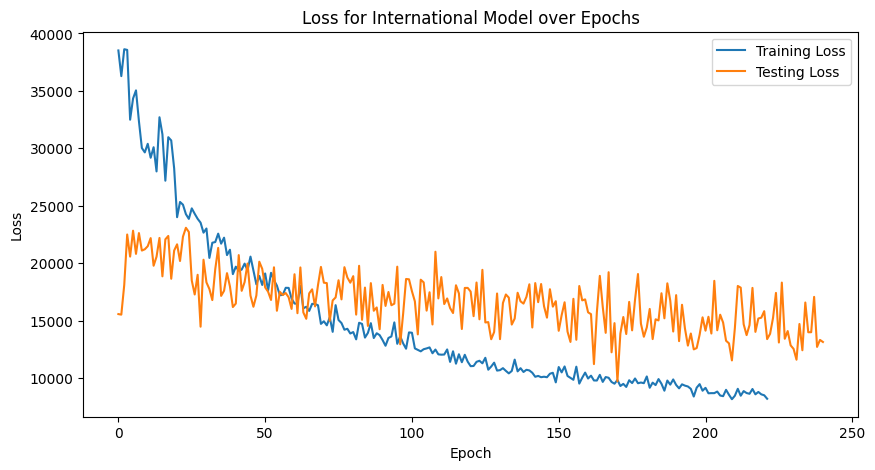

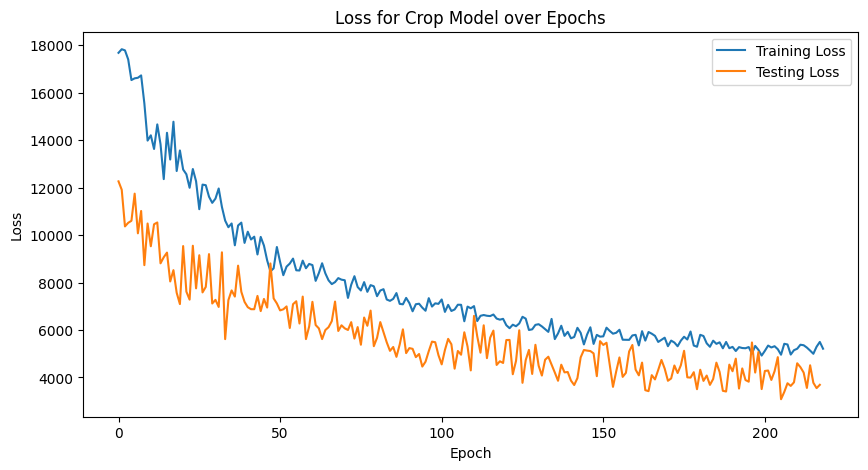

In [ ]:
import matplotlib.pyplot as plt

def filter(data):
  # Remove outliers
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)

  # Calculate the IQR
  iqr = q3 - q1

  # Determine the outlier bounds
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)

  # Filter out outliers
  return [x for x in data if lower_bound <= x <= upper_bound]

def plot_loss(data, model):
  # Plot loss
  plt.figure(figsize=(10, 5))
  plt.plot(filter(data[0]), label='Training Loss')
  plt.plot(filter(data[1]), label='Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Loss for {model} over Epochs')
  plt.legend()
  plt.show()

plot_loss(weather_losses, "Weather Model")
plot_loss(int_losses, "International Model")
plot_loss(crop_losses, "Crop Model")

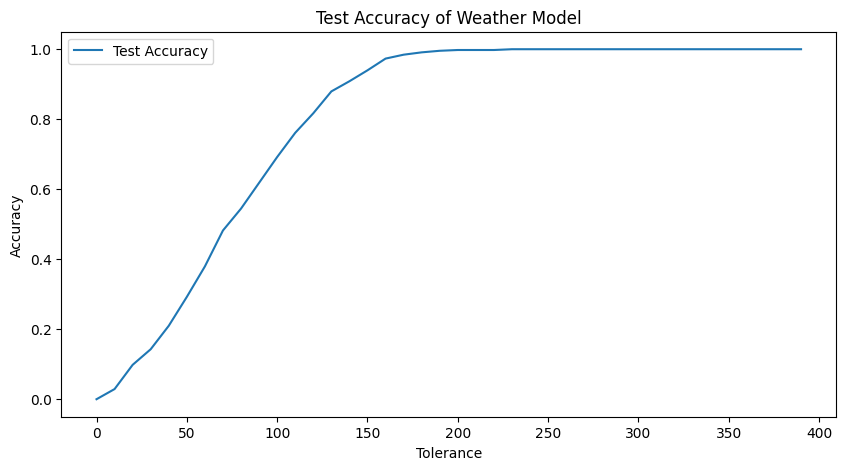

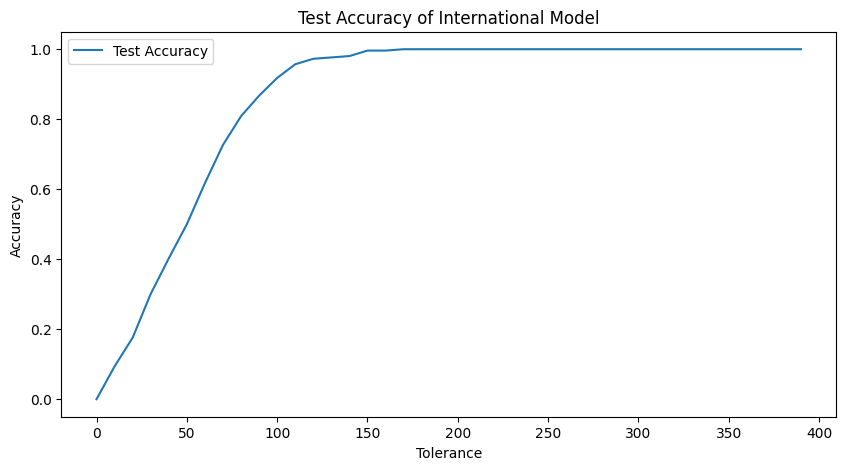

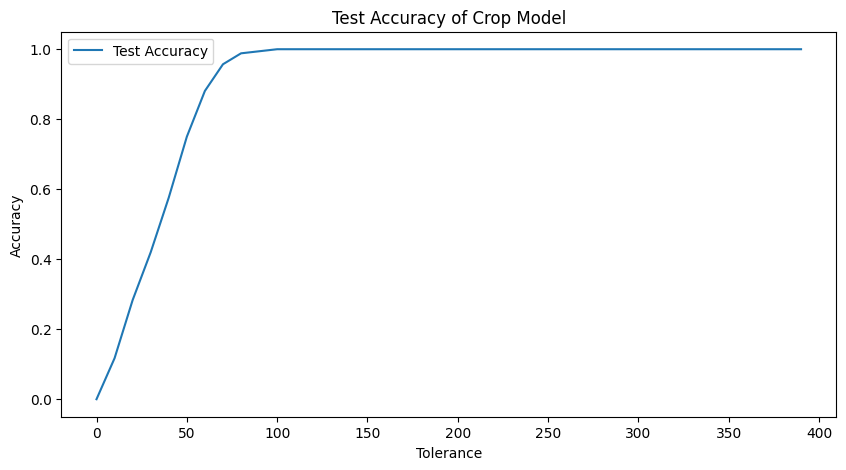

In [ ]:
def test(model, dataloader, name="Model"):
  accuracies = []
  model.eval()

  for a in range(0, 400, 10):
    accuracies.append(calculate_accuracy(model, dataloader, a))

  # Plot Accuracies
  plt.figure(figsize=(10, 5))
  plt.plot(range(0, len(accuracies) * 10, 10), accuracies, label='Test Accuracy')
  plt.xlabel('Tolerance')
  plt.ylabel('Accuracy')
  plt.title(f'Test Accuracy of {name}')
  plt.legend()
  plt.show()

test(weather_model, weather_test_dataloader, "Weather Model")
test(int_model, int_test_dataloader, "International Model")
test(crop_model, crop_test_dataloader, "Crop Model")

In [ ]:
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, sequence_length, num_layers, num_heads, dropout_rate, output_size):
        super(TimeSeriesTransformer, self).__init__()
        self.sequence_length = sequence_length
        self.feature_size = feature_size
        self.output_size = output_size

        # Encoder setup
        self.encoder_layer = TransformerEncoderLayer(
            d_model=feature_size,
            nhead=num_heads,
            dropout=dropout_rate,
            batch_first= True,
        )
        self.transformer_encoder = TransformerEncoder(
            self.encoder_layer,
            num_layers=num_layers
        )

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(sequence_length, feature_size, requires_grad=True))

        # Output layer for each timestep
        self.output_layer = nn.Linear(feature_size, output_size)

    def forward(self, src):
        src += self.positional_encoding
        encoded_output = self.transformer_encoder(src)
        output = self.output_layer(encoded_output)
        return output


In [ ]:
print("\nCrop Model Training:")
crop_model = TimeSeriesTransformer(crop_dataset.num_features(), 64, 3, crop_dataset.num_features(), 0.1, 1)
crop_losses = train(crop_model, crop_train_dataloader, crop_test_dataloader, 250, 0.0005)

int_model = TimeSeriesTransformer(int_dataset.num_features(), 64, 3, int_dataset.num_features(), 0.1, 1)
int_losses = train(int_model, int_train_dataloader, int_test_dataloader, 250, 0.001)

weather_model = TimeSeriesTransformer(weather_dataset.num_features(), 64, 3, weather_dataset.num_features(), 0.1, 1)
weather_losses = train(weather_model, weather_train_dataloader, weather_test_dataloader, 250, 0.001)


Crop Model Training:
Epoch [25/250], Train Loss: 208784.0136, Test Loss 133404.0322
Epoch [50/250], Train Loss: 171508.7117, Test Loss 102524.6660
Epoch [75/250], Train Loss: 126820.5748, Test Loss 66974.1768
Epoch [100/250], Train Loss: 84834.8139, Test Loss 35334.4456
Epoch [125/250], Train Loss: 51403.4931, Test Loss 13328.9490
Epoch [150/250], Train Loss: 30167.9946, Test Loss 2982.0730
Epoch [175/250], Train Loss: 20565.1546, Test Loss 1980.9658
Epoch [200/250], Train Loss: 17892.1823, Test Loss 4502.5984
Epoch [225/250], Train Loss: 17065.1763, Test Loss 6541.9216
Epoch [250/250], Train Loss: 16527.2976, Test Loss 6215.6713
Epoch [25/250], Train Loss: 183087.9375, Test Loss 120797.8770
Epoch [50/250], Train Loss: 112916.6434, Test Loss 62582.5430
Epoch [75/250], Train Loss: 52718.4490, Test Loss 17468.4807
Epoch [100/250], Train Loss: 23356.5168, Test Loss 1852.3684
Epoch [125/250], Train Loss: 16912.5875, Test Loss 3082.7079
Epoch [150/250], Train Loss: 16476.7579, Test Loss 48

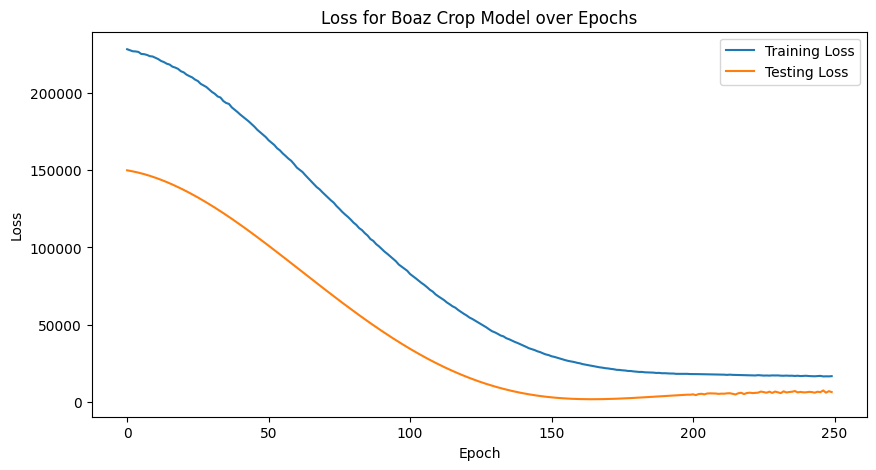

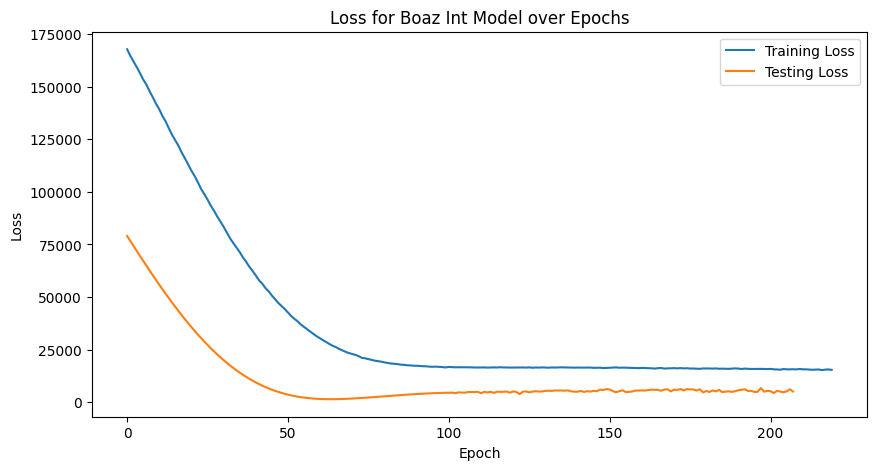

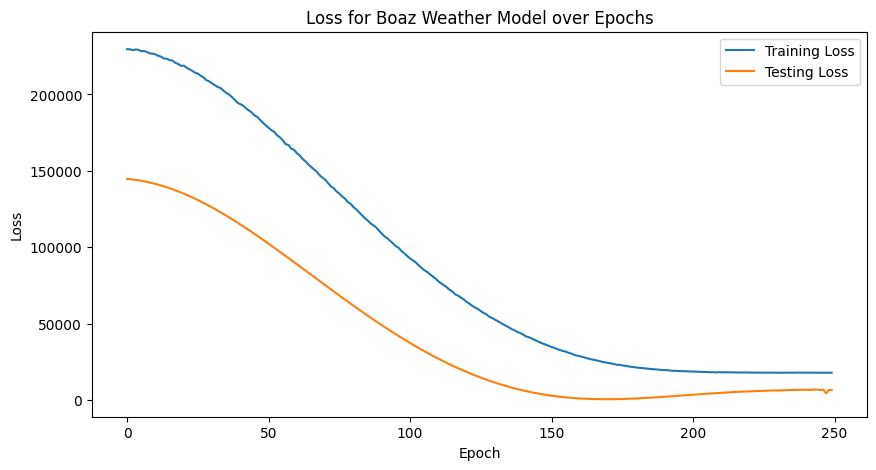

In [ ]:
plot_loss(crop_losses, "Boaz Crop Model")
plot_loss(int_losses, "Boaz Int Model")
plot_loss(weather_losses, "Boaz Weather Model")